# Making a Video from Prompts with Stable Diffusion

_by John Robinson_

I created this notebook while taking Jeremy Howards's fantastic course, ["From Deep Learning Foundations to Stable Diffusion"](https://www.fast.ai/posts/part2-2022.html).

This notebook demonstrates using [StableDiffusion](https://stability.ai/blog/stable-diffusion-public-release) to generate a movie from nothing more than a seed image and a sequence of text prompts.

[@jeremyphoward](https://twitter.com/jeremyphoward) gives a great [explanation of how it works here.](https://twitter.com/jeremyphoward/status/1583667503091548161)

![Snowy Tree](https://github.com/johnrobinsn/diffusion_experiments/blob/main/images/tree_snow.png?raw=true)

Follow me on twitter [johnrobinsn](https://twitter.com/johnrobinsn)


In [1]:
# I used conda with python 3.9

def install_dependencies():
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq --upgrade transformers diffusers ftfy
    !conda install -y -qq ffmpeg

# Uncomment this line if you'd like to install the dependencies. 
#install_dependencies()

## Imports and Setup

In [2]:
import os
import numpy

# For video display:
from IPython.display import HTML
from base64 import b64encode

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from fastcore.all import concat
from pathlib import Path

from huggingface_hub import notebook_login
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

## Authenticate with Hugging Face

To run Stable Diffusion on your computer you have to accept the model license. It's an open CreativeML OpenRail-M license that claims no rights on the outputs you generate and prohibits you from deliberately producing illegal or harmful content. The [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) provides more details. If you do accept the license, you need to be a registered user in 🤗 Hugging Face Hub and use an access token for the code to work. You have two options to provide your access token:

* Use the `huggingface-cli login` command-line tool in your terminal and paste your token when prompted. It will be saved in a file in your computer.
* Or use `notebook_login()` in a notebook, which does the same thing.

In [3]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

## Load Pretrained Hugging Face Models

In [4]:
# Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
# hyper parameters match those used during training the model
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.0.mlp.fc1.bias', 'vision_model.encoder.layers.11.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.out_proj.bias', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.4.self_attn.q_proj.weight', 'vision_model.encoder.layers.2.self_attn.out_proj.bias', 'vision_model.encoder.layers.6.self_attn.k_proj.weight', 'vision_model.encoder.layers.3.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.mlp.fc1.weight', 'vision_model.encoder.layers.18.self_attn.q_proj.weight', 'vision_model.encoder.layers.10.mlp.fc2.bias', 'vision_model.encoder.layers.4.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.mlp.fc2.weight', 'vision_model.encoder.layers.16.self_attn.k_proj.weight', 'vision_model.encoder.layers

In [5]:
vae_magic = 0.18215 # vae model trained with a scale term to get closer to unit variance

## Functions to Convert between Latents and Images

In [6]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1)
    latent = latent.latent_dist.sample()*vae_magic      
    return latent

In [7]:
def _latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs/2+0.5).clamp(0,1)
    return imgs

In [8]:
def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs/2+0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs*255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

In [9]:
def clamp(n,smallest,largest): return max(smallest,min(n,largest))

In [10]:
def generate_image_from_embedding(text_embeddings,noise,im_latents=None,seed=32):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 50  #30           # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance

    max_length = tokenizer.model_max_length
    uncond_input = tokenizer(
      [""], padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0] 
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    
    if im_latents != None:
        # img2img
        start_step = 10
        #pass in noise...
        #noise = torch.randn_like(im_latents)
        latents = scheduler.add_noise(im_latents,noise,timesteps=torch.tensor([scheduler.timesteps[start_step]]))
        latents = latents.to(torch_device).float()
    else:
        # just text prompts
        start_step = -1 # disable branching below
        latents = torch.randn((1,unet.in_channels,height//8,width//8))#,generator=generator)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma # scale to initial amount of noise for t0

    for i, t in tqdm(enumerate(scheduler.timesteps),total=num_inference_steps):
        if i > start_step:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents2images(latents)[0],latents

In [21]:
def get_embedding_for_prompt(prompt):
    tokens = tokenizer([prompt], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

def generate_image_from_embeddings(embeddings,noise,im_latents=None,pos = 0,seed=32):
    # integer part of pos is used for prompt index;
    # fractional part of pos is used to "lerp" between the embeddings
    #noise = torch.randn_like(im_latents)
    l = len(embeddings)
    if l > 1:
        index = clamp(int(pos),0,len(embeddings)-2)
        mix = clamp(pos-index,0,1)
        mixed_embeddings = (embeddings[index]*(1-mix)+embeddings[index+1]*mix)
        return generate_image_from_embedding(mixed_embeddings,noise,im_latents,seed=seed)
    elif l == 1:
        return generate_image_from_embedding(embeddings[0],noise,im_latents,seed=seed)
    else:
        raise Exception("Must provide at least one embedding")
        
def generate_movie_from_prompts(prompts,outdir,im_latents=None,fps=12,seconds_per_prompt=2,seed=32,
                                update_latents=False,update_noise=False):
    if not os.path.exists(outdir): os.mkdir(outdir)
    num_prompts = len(prompts)
    num_frames = (num_prompts-1) * seconds_per_prompt * fps
    embeddings = [get_embedding_for_prompt(p) for p in prompts]
    generator = torch.manual_seed(seed)
    noise = torch.randn_like(im_latents)
    for f in tqdm(range(0,num_frames)):
        im,new_latents = generate_image_from_embeddings(embeddings,noise,im_latents,(f/num_frames)*num_prompts,seed=seed)
        if update_latents:
            im_latents = new_latents
        if update_noise:
            noise = torch.randn_like(im_latents)
        
        '''
        if im_latents == None:
            print('grabbing latent from first pass')
            im_latents = new_latents
        '''
        im.save(f'{outdir}/{f:04}.jpg')
        '''
        plt.imshow(im)
        plt.show()
        plt.imshow(latents2images(im_latents)[0])
        plt.show()
        '''

In [22]:
def show_frames(dir):
    frame_files = Path(dir).ls().sorted(key=lambda f: int(f.with_suffix('').name))
    f, axarr = plt.subplots(1,len(frame_files),figsize=(3*len(frame_files),3))
    for i,f in enumerate(frame_files):
        axarr[i].imshow(Image.open(f))


## Create Video from Images

In [23]:
def create_movie(dir,movie_name,fps=12):
    if os.path.exists(movie_name): os.remove(movie_name)
    !ffmpeg -v 1 -y -f image2 -framerate {fps} -i {dir}/%04d.jpg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p {movie_name}

def embed_movie(movie_name):
    mp4 = open(movie_name,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    return"""
    <video width=600 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url

# Show Problem Behavior

There appears to be some numeric problem caused when adding the same noise to a latent generated using that noise as demonstrated below.

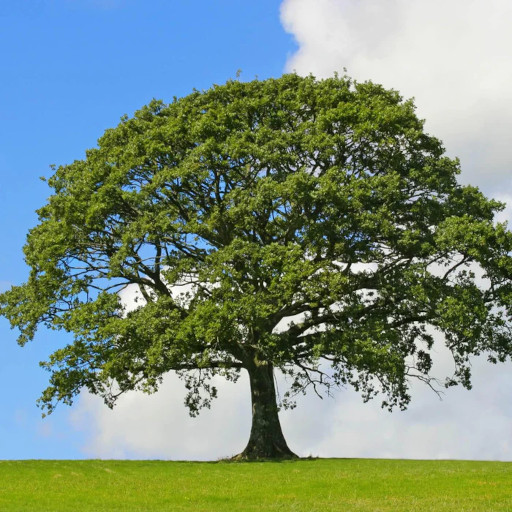

In [24]:
img = Image.open('./images/oak_tree.jpg').resize((512,512));img

In [25]:
encoded = image2latent(img); encoded.shape

torch.Size([1, 4, 64, 64])

In [26]:
tree_prompts = [
    "An oak tree with bare branches in the winter snowing blizzard bleak",
    "A barren oak tree with no leaves and grass on the ground",
    "An oak tree in the spring with bright green leaves",
    "An oak tree in the summer with dark green leaves with a squirrel on the trunk",
    "An oak tree in the fall with colorful leaves on the ground",
    "An barren oak tree with no leaves in the fall leaves on the ground long shadows",
    "An oak tree with bare branches in the winter snowing blizzard bleak"
]


### Demonstrate Original "Good (but invalid) Movie" Behavior

Unfortunately due to a silly bug (readonly global variables are evil) every frame of my movie was generated using the encoded image as the input.  

**While this did result in "good looking/stable" video.  It didn't demonstrate as I'd hoped using the generated latent from the previous frame as input to this frame.**

As a starting point, let's demonstrate the "good looking" but invalid baseline by passing in False to both the update_latents and update_noise parameters.

In [17]:
# Let's only do the first 3 prompts since it's enough to demonstrate the issue
tree_prompts_subset = tree_prompts[:3]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

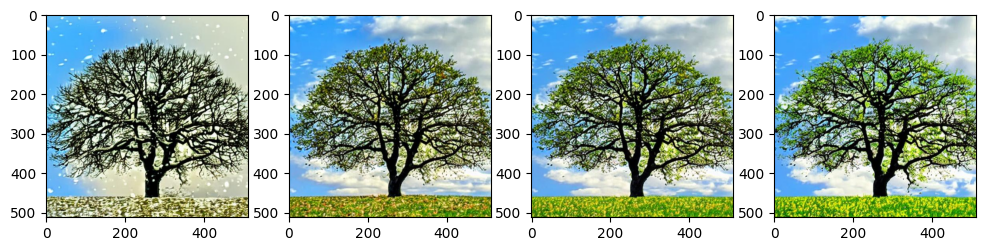

In [18]:
# Let's make a quick movie to help debug the prompts

img_dir = 'tree_baseline'
movie = 'tree_baseline.mp4'

generate_movie_from_prompts(tree_prompts_subset,img_dir,encoded,fps=2,seconds_per_prompt=1,seed=17390125398225616219,
                           update_latents=False,update_noise=False)


show_frames(img_dir)

#create_movie(img_dir,movie,fps=1)
#HTML(embed_movie(movie))


### Demonstrate Degenerate Behavior
In order to get a "similarly" generated image from frame to frame, I use the same noise on every generated frame.  However if you apply this noise to a latent generated with that same noise, the generated latents degrade over time.

To demonstrate this pass in True for the update_latents parameter and False for the update_noise parameter.

This will have the effect of using the latent from the previously generated frame as input to generating this frame.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

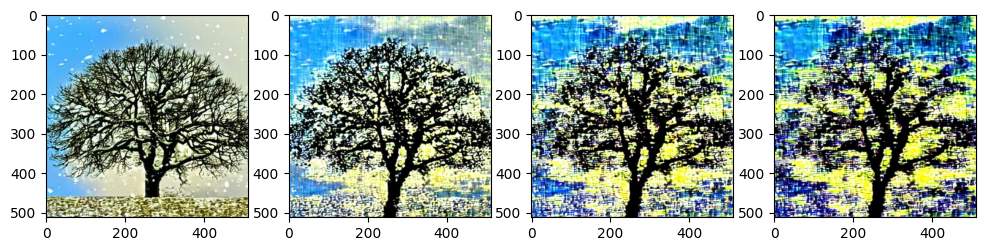

In [19]:
# Let's make a quick movie to help debug the prompts

img_dir = 'tree_update_latent'
movie = 'tree_update_latent.mp4'

generate_movie_from_prompts(tree_prompts_subset,img_dir,encoded,fps=2,seconds_per_prompt=1,seed=17390125398225616219,
                           update_latents=True,update_noise=False)

show_frames(img_dir)

#create_movie(img_dir,movie,fps=1)
#HTML(embed_movie(movie))


### Demonstrate Updating Noise and Latents on Every Frame

This fixes the problem with degradation.  But has the undesired effect of causing the "style" of the generated images to vary wildly from frame to frame.

To demonstrate this pass in True for the update_latents parameter and True for the update_noise parameter.

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

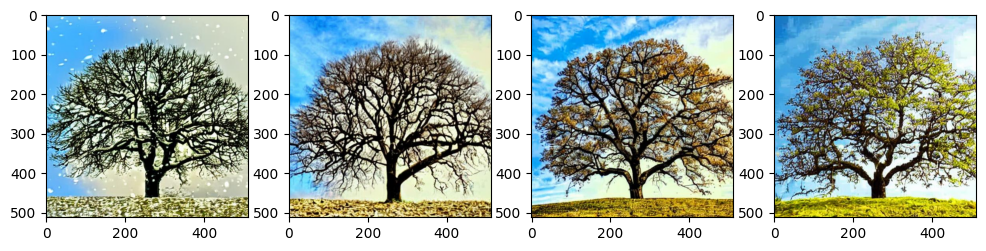

In [20]:
# Let's make a quick movie to help debug the prompts

img_dir = 'tree_update_noise'
movie = 'tree_update_noise.mp4'

generate_movie_from_prompts(tree_prompts_subset,img_dir,encoded,fps=2,seconds_per_prompt=1,seed=17390125398225616219,
                           update_latents=True,update_noise=True)

show_frames(img_dir)

#create_movie(img_dir,movie,fps=1)
#HTML(embed_movie(movie))